# Frontal Face Detector 

정면 얼굴 검출기

https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/

HOG 기반의 얼굴 포인트 검출 모델

## 의존성 패키지 설치

OpenCV for Python

https://opencv.org/

* opencv-python: 메인 모듈
* opencv-contrib-python: 확장 모듈

C++ Tookit for Machine Learning

http://dlib.net/


In [1]:
# 설치
!pip install -q --upgrade pip
!pip install -q opencv-python opencv-contrib-python
!pip install -q dlib

## 모델 다운로드

* https://github.com/davisking/dlib-models
* https://github.com/davisking/dlib-models/blob/master/shape_predictor_68_face_landmarks.dat.bz2

In [1]:
!rm -f /tmp/shape_predictor_68_face_landmarks.dat*
!wget -q -P /tmp https://raw.githubusercontent.com/davisking/dlib-models/master/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d /tmp/shape_predictor_68_face_landmarks.dat.bz2
!ls -al /tmp | grep shape_predictor_68_face_landmarks

-rw-r--r-- 1 skp  skp  99693937  7월 10 11:48 shape_predictor_68_face_landmarks.dat


## 테스트 데이터 다운로드

* https://github.com/intel-iot-devkit/sample-videos
* https://github.com/intel-iot-devkit/sample-videos/raw/master/face-demographics-walking-and-pause.mp4

In [2]:
!rm -f /tmp/face-demographics-walking-and-pause*
!wget -q -P /tmp https://github.com/intel-iot-devkit/sample-videos/raw/master/face-demographics-walking-and-pause.mp4 
!ls -al /tmp | grep face-demographics-walking-and-pause

-rw-r--r-- 1 skp  skp   9406029  7월 10 11:49 face-demographics-walking-and-pause.mp4


In [3]:
from IPython.display import clear_output, Image, display
import cv2, time, dlib
import numpy as np

curr_time = 0

def getFPS():
    global curr_time
    if curr_time == 0:
        curr_time = time.time()
        fps = 0
    else:
        last_time = curr_time
        curr_time = time.time()
        fps = 1. / (curr_time - last_time)
    return fps

def putText(frame, text):
    height, width, _ = frame.shape
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    org = (0, height - 10)
    font_color = (255, 0, 0)
    thickness = 2
    cv2.putText(frame, text, org, font, font_scale, font_color, thickness)
    return frame

def resize(frame, scale=0.2):
    height, width, _ = frame.shape
    frame = cv2.resize(frame, (int(width * scale), int(height * scale)))
    return frame

def drawFaceRectangle(frame, face):
    pt1 = (face.left(), face.top())
    pt2 = (face.right(), face.bottom())
    color = (255, 0, 0)
    thickness = 2
    line_type = cv2.LINE_AA
    frame = cv2.rectangle(frame, pt1, pt2, color, thickness, line_type)
    return frame

def drawFaceShape(frame, shape):
    shape_2d = np.array([[p.x, p.y] for p in shape.parts()])
    radius=1
    color=(255, 0, 0)
    thickness=2
    line_type=cv2.LINE_AA
    for s in shape_2d:
        center=tuple(s)        
        cv2.circle(frame, center, radius, color, thickness, line_type)
    return frame
    
def getImage(frame):
    ret, png = cv2.imencode('.png', frame)
    return Image(png)


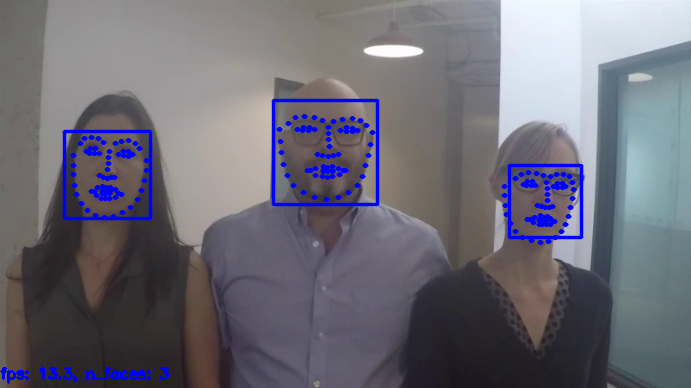

In [4]:
face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor('/tmp/shape_predictor_68_face_landmarks.dat')

video = cv2.VideoCapture("/tmp/face-demographics-walking-and-pause.mp4")

fidx = 0
while(True):
    try:
        clear_output(wait=True)
        ret, frame = video.read()
        if not ret:
            break
        fidx += 1
        frame = resize(frame, 0.9)
        
        faces = face_detector(frame)
        n_faces = len(faces)
        
        for face in faces:
            frame = drawFaceRectangle(frame, face)
        
            face_shape = shape_predictor(frame, face)
            frame = drawFaceShape(frame, face_shape)
        
            # compute face center
            shape_2d = np.array([[p.x, p.y] for p in face_shape.parts()])            
            center_x, center_y = np.mean(shape_2d, axis=0).astype(np.int)
            # compute face boundaries
            min_coords = np.min(shape_2d, axis=0)
            max_coords = np.max(shape_2d, axis=0)
            # compute face size
            face_size = int(max(max_coords - min_coords) * 1.5)
                
        fps = getFPS()
        text = f"fps: {fps:.1f}, n_faces: {n_faces}"
        frame = putText(frame, text)
        
        img = getImage(frame)
        display(img)        
        #time.sleep(0.001)
    except KeyboardInterrupt:
        # KeyboardInterrupt 를 raise 하기 위해서는 I 키를 두번 누름 
        video.release()